# Book Glancer - Text Analysis Backend

An NLP text analysis toolkit for analyzing books and their translations. This notebook demonstrates NLP techniques including:
- Text tokenization and preprocessing
- Word frequency analysis
- N-gram extraction
- Named Entity Recognition (NER)
- Visualization with word clouds and bar plots
- experimental LLM layer: natural language dialog via locally stored LLM model

**Author:** Michal Kubina  
**Default Example:** 'R.U.R' by Karel Čapek (public domain)  
**License:** Non-commercial use only

## 1. Setup and Dependencies

Install required packages (uncomment if needed):

In [1]:
# !pip install pandas PyPDF2 filetype nltk matplotlib seaborn wordcloud spacy
# !python -m spacy download en_core_web_sm

### Import Libraries

In [2]:
import pandas as pd
import PyPDF2
import filetype
import random
from collections import Counter

# NLP libraries
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.util import ngrams

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# NER with spaCy
import spacy

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

### Download NLTK Data

In [3]:
# Download required NLTK resources
nltk_resources = [
    'punkt',
    'punkt_tab',
    'stopwords',
    'wordnet',
    'averaged_perceptron_tagger',
    'averaged_perceptron_tagger_eng'
]

for resource in nltk_resources:
    try:
        nltk.download(resource, quiet=True)
    except:
        print(f"Could not download {resource}")

## 2. File Loading Functions

In [4]:
def load_text_file(filepath):
    """
    Load a text file and return its contents.
    """
    with open(filepath, 'r', encoding='utf-8') as f:
        return f.read()


def load_pdf_file(filepath):
    """
    Load a PDF file and extract text from all pages.
    """
    reader = PyPDF2.PdfReader(filepath)
    content = ''
    for page in reader.pages:
        content += page.extract_text()
    return content


def load_book(filepath):
    """
    Automatically detect file type and load content.
    """
    if filepath.endswith('.pdf'):
        return load_pdf_file(filepath)
    else:
        return load_text_file(filepath)

## 3. Load Your Book

Replace the filepath with your own book file (TXT or PDF):

In [5]:
# Example: Load default book (update path as needed)
book_path = 'sources/rur.txt'  # Change this to your book path
translation_path = 'sources/rur_cs.txt'  # Optional: translation

# Load the content
content = load_book(book_path)

# Optionally load translation
try:
    content_cs = load_book(translation_path)
    has_translation = True
except:
    content_cs = None
    has_translation = False

print(f"Book loaded: {len(content)} characters")
if has_translation:
    print(f"Translation loaded: {len(content_cs)} characters")

Book loaded: 125641 characters
Translation loaded: 117174 characters


## 4. Basic Text Statistics

In [6]:
def get_text_statistics(text):
    """
    Calculate basic statistics for a text.
    """
    tokens = word_tokenize(text)
    return {
        'words': len(tokens),
        'characters': len(text),
        'standard_pages': len(text) / 1800
    }

# Display statistics
stats = get_text_statistics(content)
print("Original Text Statistics:")
print(f"  Words: {stats['words']:,}")
print(f"  Characters: {stats['characters']:,}")
print(f"  Standard Pages: {stats['standard_pages']:.2f}")

if has_translation:
    stats_cs = get_text_statistics(content_cs)
    print("\nTranslation Statistics:")
    print(f"  Words: {stats_cs['words']:,}")
    print(f"  Characters: {stats_cs['characters']:,}")
    print(f"  Standard Pages: {stats_cs['standard_pages']:.2f}")

Original Text Statistics:
  Words: 29,373
  Characters: 125,641
  Standard Pages: 69.80

Translation Statistics:
  Words: 26,405
  Characters: 117,174
  Standard Pages: 65.10


## 5. Random Text Sampling

In [7]:
def get_random_excerpt(text, length=600):
    """
    Extract a random excerpt from the middle portion of the text.
    """
    start = len(text) // 4
    end = len(text) - len(text) // 4
    random_start = random.randint(start, end - length)
    return text[random_start:random_start + length]


# Display random excerpts
print("RANDOM EXCERPT FROM BOOK:")
print("=" * 80)
print(get_random_excerpt(content))
print("=" * 80)

if has_translation:
    print("\nRANDOM EXCERPT FROM TRANSLATION:")
    print("=" * 80)
    print(get_random_excerpt(content_cs))
    print("=" * 80)

RANDOM EXCERPT FROM BOOK:
y it’s quite incredible.

HELENA. I’m a stupid girl. Send me back by the first ship.

DR. GALL. Not for anything in the world, Miss Glory. Why should we send
you back?

DOMIN. If it would amuse you, Miss Glory, I’ll take you down to the
Robot warehouse. It holds about three hundred thousand of them.

BUSMAN. Three hundred and forty-seven thousand.

DOMIN. Good, and you can say whatever you like to them. You can read
the Bible, recite the multiplication table, whatever you please. You
can even preach to them about human rights.

HELENA. Oh, I think that if you were to show them a little love.



RANDOM EXCERPT FROM TRANSLATION:
čka a spustí basem) Už je po ní! Už je
    po ní!

Dr. Gall: (baryton) Už je po ní!

Domin: (tenor) Už je po ní!

Hallemeier: Už nás nikdy nedohoní

Helena: (s lahví a sklenicemi ve dveřích) Kdo vás nedohoní? Co máte?

Hallemeier: Máme radost. Máme vás. Máme všechno. Kruci turci, zrovna je
    tomu deset let, co jste přijela.

Dr. Gall: 

## 6. Text Preprocessing and Tokenization

In [8]:
def preprocess_text(text, language='english'):
    """
    Tokenize, clean, and lemmatize text.
    """
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Define stopwords (including custom ones)
    stops = set(stopwords.words(language) + 
                ['said', 'saw', 'see', 'copyright', 'u', 'looked', 'made', 'got', 'asked'])
    
    # Remove stopwords and non-alphanumeric tokens
    clean_tokens = [token for token in tokens 
                   if token.lower() not in stops and token.isalnum()]
    
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(token) for token in clean_tokens]
    
    # Remove additional stop lemmas
    stop_lemmas = {'look', 'know', 'u', 'ask', 'go', 'get', 'make', 'way'}
    clean_lemmas = [lemma for lemma in lemmas if lemma not in stop_lemmas]
    
    # POS tagging and filtering
    tagged = pos_tag(clean_lemmas)
    value_tags = ['NN', 'NNS', 'JJ', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
    value_words = [word[0] for word in tagged if word[1] in value_tags]
    
    return value_words

# Process the text
print("Processing text...")
processed_words = preprocess_text(content)
print(f"Processed {len(processed_words):,} meaningful words")

Processing text...
Processed 5,051 meaningful words


## 7. Word Frequency Analysis

In [9]:
# Calculate frequency distribution
freq_dist = FreqDist(processed_words)
most_common = freq_dist.most_common(25)

# Display top words
print("Top 25 Most Common Words:")
print("=" * 40)
for word, count in most_common:
    print(f"{word:20} {count:5}")

Top 25 Most Common Words:
table                   53
year                    42
man                     42
hand                    37
factory                 36
come                    35
world                   32
human                   31
good                    28
work                    28
want                    28
think                   28
window                  27
everything              27
take                    25
life                    25
say                     25
room                    24
old                     23
thing                   23
cross                   23
nothing                 22
desk                    22
chair                   22
something               21


### Visualize Word Frequencies

C:\Users\mikub\AppData\Local\Temp\ipykernel_22276\212838868.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='viridis', orient='h')


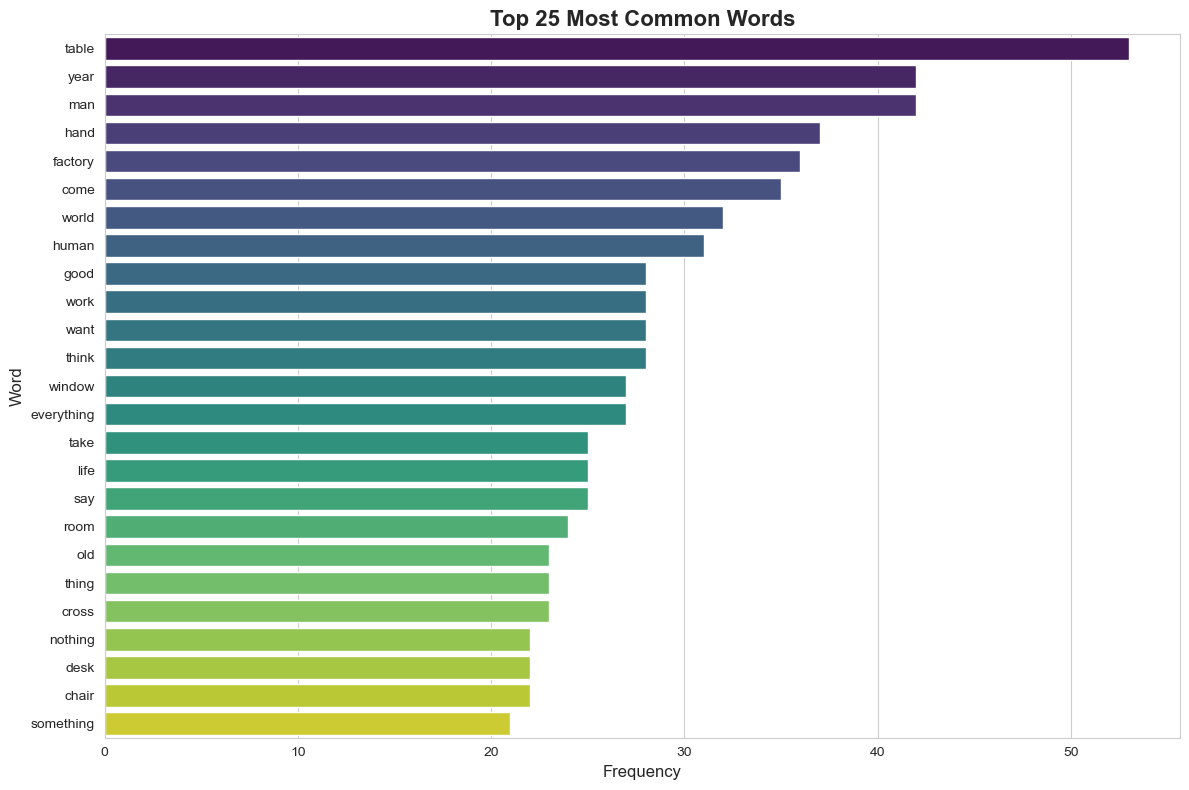

In [10]:
# Bar plot of most common words
plt.figure(figsize=(12, 8))
words, counts = zip(*most_common)
sns.barplot(x=list(counts), y=list(words), palette='viridis', orient='h')
plt.title('Top 25 Most Common Words', fontsize=16, fontweight='bold')
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Word', fontsize=12)
plt.tight_layout()
plt.show()

### Word Cloud Visualization

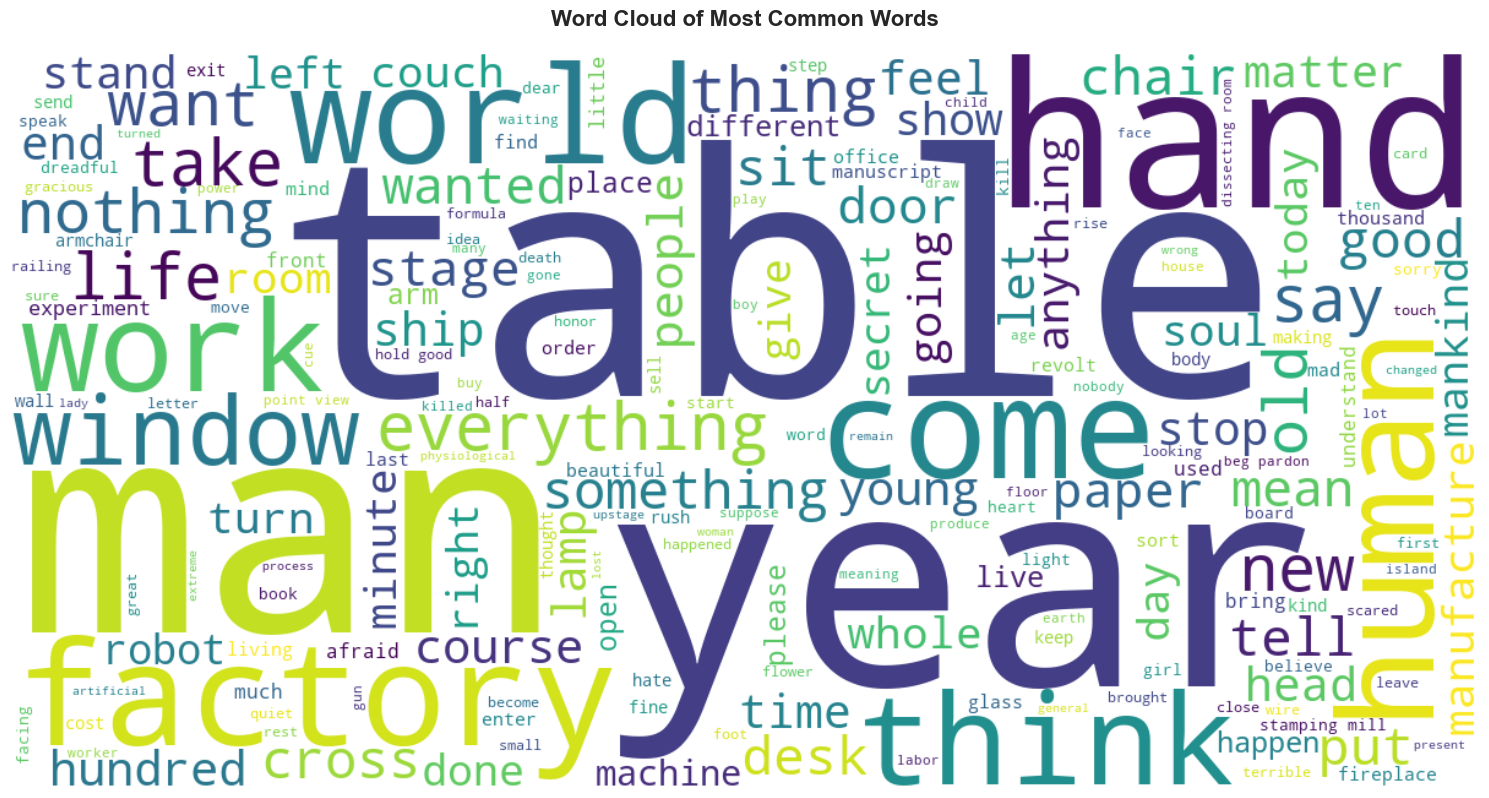

In [11]:
# Generate word cloud
text_for_cloud = ' '.join(processed_words)
wordcloud = WordCloud(width=1200, height=600, 
                     background_color='white',
                     colormap='viridis').generate(text_for_cloud)

plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Common Words', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

## 8. N-gram Analysis (Bigrams)

In [12]:
# Generate bigrams
bigrams_list = list(ngrams(processed_words, 2))
bigram_freq = FreqDist(bigrams_list)
top_bigrams = bigram_freq.most_common(20)

# Display top bigrams
print("Top 20 Most Common Phrases (Bigrams):")
print("=" * 50)
for bigram, count in top_bigrams:
    phrase = ' '.join(bigram)
    print(f"{phrase:30} {count:5}")

Top 20 Most Common Phrases (Bigrams):
human being                       17
stamping mill                      8
hold good                          7
beg pardon                         6
point view                         6
dissecting room                    6
school book                        5
old man                            4
want master                        4
hand hand                          4
young man                          3
year year                          3
beg acknowledge                    3
acknowledge receipt                3
receipt order                      3
manufacture artificial             3
couch sits                         3
living matter                      3
test tube                          3
ten year                           3


### Bigram Word Cloud

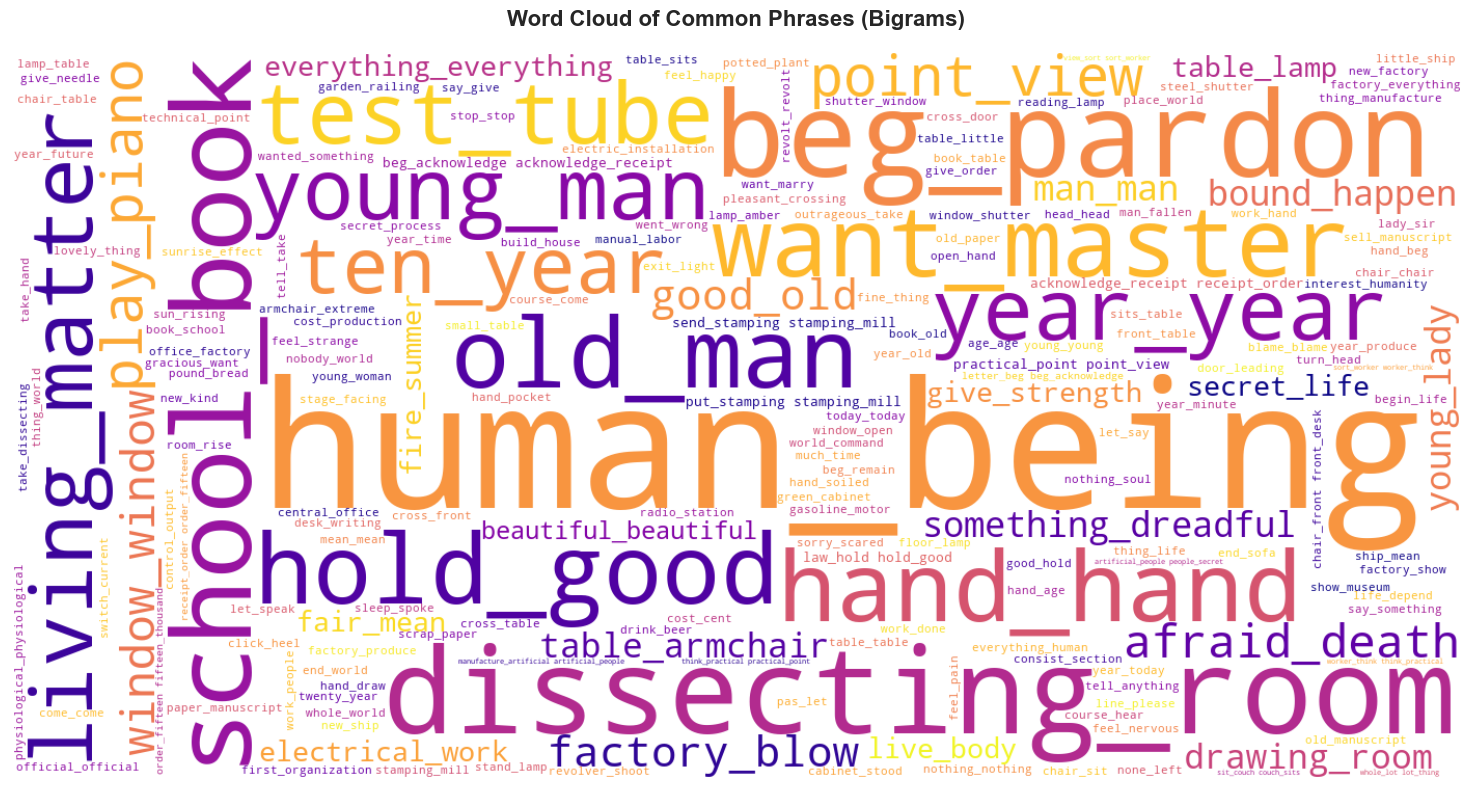

In [13]:
# Create underscore-connected bigrams for word cloud
bigrams_text = ' '.join(['_'.join(bigram) for bigram in bigrams_list])
wordcloud_bigrams = WordCloud(width=1400, height=700,
                             background_color='white',
                             colormap='plasma').generate(bigrams_text)

plt.figure(figsize=(16, 8))
plt.imshow(wordcloud_bigrams, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Common Phrases (Bigrams)', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

## 9. Named Entity Recognition (NER) with spaCy

In [14]:
# Load spaCy model
print("Loading spaCy model...")
try:
    nlp = spacy.load('en_core_web_sm')
except:
    print("Downloading spaCy model...")
    spacy.cli.download('en_core_web_sm')
    nlp = spacy.load('en_core_web_sm')

# Increase max length for large texts
nlp.max_length = len(content) + 1000

# Process the text
print("REcognizing entitites...")
doc = nlp(content)
print("Entities recognized")

Loading spaCy model...
REcognizing entitites...
Entities recognized


### Extract and Analyze Entities

In [15]:
# Extract entities by type
entities = [(ent.text, ent.label_) for ent in doc.ents]

persons = [ent for ent in entities if ent[1] == 'PERSON']
places = [ent for ent in entities if ent[1] == 'GPE']
organizations = [ent for ent in entities if ent[1] == 'ORG']

# Count occurrences
person_counts = Counter(persons).most_common(20)
place_counts = Counter(places).most_common(20)
org_counts = Counter(organizations).most_common(20)

print(f"Found {len(set(persons))} unique persons")
print(f"Found {len(set(places))} unique places")
print(f"Found {len(set(organizations))} unique organizations")

Found 145 unique persons
Found 25 unique places
Found 98 unique organizations


### Display Top Persons

In [16]:
print("\nTop 20 Persons Mentioned:")
print("=" * 50)
for (person, label), count in person_counts:
    print(f"{person:30} (Count: {count})")


Top 20 Persons Mentioned:
Miss Glory                     (Count: 55)
Gall                           (Count: 30)
Harry                          (Count: 30)
DOMIN                          (Count: 29)
Fabry                          (Count: 26)
Rossum                         (Count: 24)
Busman                         (Count: 22)
Domin                          (Count: 20)
Sulla                          (Count: 20)
Hallemeier                     (Count: 10)
Primus                         (Count: 10)
Robot                          (Count: 9)
Turns                          (Count: 8)
L.                             (Count: 8)
Looks                          (Count: 7)
Jove                           (Count: 6)
Glory                          (Count: 5)
R.C.                           (Count: 5)
Crossing                       (Count: 4)
Off R.                         (Count: 4)


### Display Top Places

In [17]:
print("\nTop 20 Places Mentioned:")
print("=" * 50)
for (place, label), count in place_counts:
    print(f"{place:30} (Count: {count})")


Top 20 Places Mentioned:
L.C.                           (Count: 35)
R.C.                           (Count: 10)
DR                             (Count: 4)
New York                       (Count: 3)
America                        (Count: 3)
n’t                            (Count: 3)
perhaps--                      (Count: 2)
Center                         (Count: 2)
Spelling                       (Count: 2)
Robots                         (Count: 2)
Adam and Eve                   (Count: 1)
Southampton                    (Count: 1)
England                        (Count: 1)
U.S.A.                         (Count: 1)
Hamburg                        (Count: 1)
Germany                        (Count: 1)
Robot                          (Count: 1)
Pennsylvania                   (Count: 1)
Radius                         (Count: 1)
Amelia                         (Count: 1)


### Display Top Organizations

In [18]:
print("\nTop 20 Organizations Mentioned:")
print("=" * 50)
for (org, label), count in org_counts:
    print(f"{org:30} (Count: {count})")


Top 20 Organizations Mentioned:
DOMIN                          (Count: 319)
HALLEMEIER                     (Count: 71)
Helena                         (Count: 37)
Robots                         (Count: 27)
HELENA                         (Count: 26)
Nana                           (Count: 25)
BUSMAN                         (Count: 21)
SULLA                          (Count: 19)
MEN                            (Count: 17)
ROBOTS                         (Count: 14)
GALL                           (Count: 12)
Marius                         (Count: 6)
EPILOGUE                       (Count: 4)
NANA                           (Count: 4)
FABRY                          (Count: 3)
CURTAIN                        (Count: 3)
Robotess                       (Count: 2)
HELENA
                        (Count: 2)
L.                             (Count: 2)
the Humanity League            (Count: 2)


## 10. Summary Report

In [19]:
print("="*80)
print("BOOK ANALYSIS SUMMARY")
print("="*80)
print(f"\nText Statistics:")
print(f"  Total words: {stats['words']:,}")
print(f"  Total characters: {stats['characters']:,}")
print(f"  Estimated pages: {stats['standard_pages']:.1f}")
print(f"\nProcessed Data:")
print(f"  Meaningful words (after cleaning): {len(processed_words):,}")
print(f"  Unique words: {len(set(processed_words)):,}")
print(f"  Unique bigrams: {len(set(bigrams_list)):,}")
print(f"\nNamed Entities:")
print(f"  Persons: {len(set(persons))}")
print(f"  Places: {len(set(places))}")
print(f"  Organizations: {len(set(organizations))}")
print(f"\nTop 3 Most Common Words:")
for i, (word, count) in enumerate(most_common[:3], 1):
    print(f"  {i}. {word} ({count} times)")
print("\n" + "="*80)

BOOK ANALYSIS SUMMARY

Text Statistics:
  Total words: 29,373
  Total characters: 125,641
  Estimated pages: 69.8

Processed Data:
  Meaningful words (after cleaning): 5,051
  Unique words: 1,726
  Unique bigrams: 4,747

Named Entities:
  Persons: 145
  Places: 25
  Organizations: 98

Top 3 Most Common Words:
  1. table (53 times)
  2. year (42 times)
  3. man (42 times)



## 11. Export Results (Optional)

Save analysis results to CSV files for further use:

In [20]:
# Create DataFrames
word_freq_df = pd.DataFrame(most_common, columns=['Word', 'Frequency'])
bigram_df = pd.DataFrame(
    [(' '.join(bigram), count) for bigram, count in top_bigrams],
    columns=['Bigram', 'Frequency']
)
persons_df = pd.DataFrame(
    [(name, count) for (name, _), count in person_counts],
    columns=['Person', 'Count']
)

# Save to CSV (uncomment to use)
# word_freq_df.to_csv('word_frequencies.csv', index=False)
# bigram_df.to_csv('bigram_frequencies.csv', index=False)
# persons_df.to_csv('person_entities.csv', index=False)

print("Analysis complete! Results can be exported to CSV if needed.")

Analysis complete! Results can be exported to CSV if needed.


## 12. Natural dialog about book content / LLM layer (experimental)

Save analysis results to CSV files for further use:

**Requirements:**
- Ollama must be installed locally: https://ollama.com/download
- Run `ollama pull gemma2:2b` in terminal to download the model
- Install Python client: `pip install ollama`

This feature allows you to ask questions about the book's content using a local LLM, no could, all stays on-device

In [ ]:
import ollama

user_prompt = input("Ask a question about the book: ")

prompt = f"""You are a book editor. You are great at getting reliable insights from a book and interpreting them. 
Use ONLY the following book text to answer the question.

Book text:
{content}

Question: {user_prompt}

Answer based only on the book text above:"""

response = ollama.chat(
    model="gemma2:2b",
    messages=[{"role": "user", "content": prompt}],
    options={"num_ctx": 128000}
)

print(response["message"]["content"])

Example of natural dialog in front-end UI

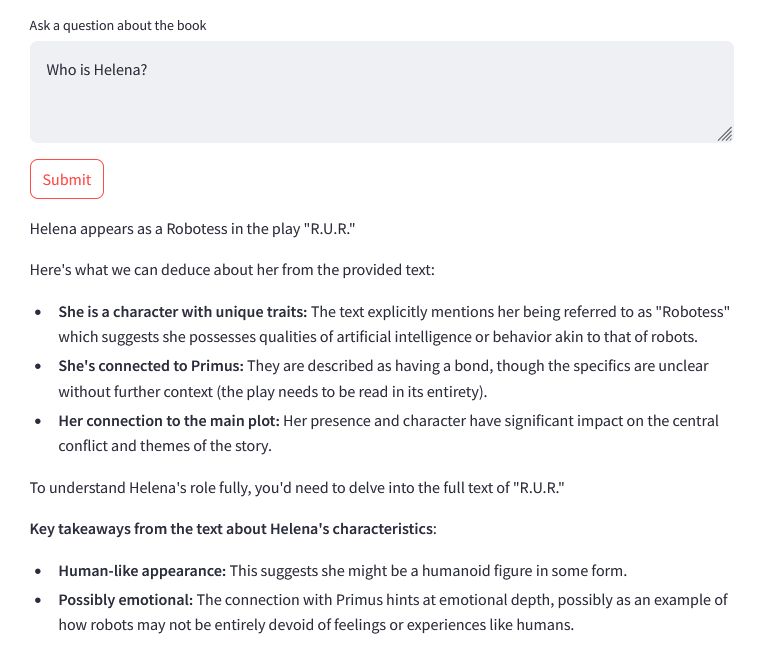